In [1]:
import os
import sys
import glob

import numpy as np
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt
import pickle

In [2]:
def readNaluOutput(folder,basename,ts):
    tmp = glob.glob(folder + basename + "*")[0].split(".")

    fullBaseName = tmp[0] + "." + tmp[1] + "."

    numNodes = int(glob.glob(folder + basename + "*")[0].split(basename)[1].split(".")[2])

    fillSize = 4
    if   (numNodes <= 10):    fillSize = 1
    elif (numNodes <= 100):   fillSize = 2
    elif (numNodes <= 1000):  fillSize = 3
    
    for j in range(0,numNodes):
        fn = fullBaseName + str(numNodes) + "." + str(j).zfill(fillSize)
        f = nc.Dataset(fn,"r")
        
        if (j == 0):
            print ("Analysis for time: ", f["time_whole"][ts])
            sys.stdout.write("Reading %s output files..." % numNodes)

        dataFrameDict = {'x':f['coordx'], 'y':f['coordy'], 'z':f['coordz']}
    
        for i in range(0,f.dimensions['num_nod_var'].size):
            varName = f.variables['name_nod_var'][i].data.tostring()
            varName = varName.decode().split('\x00')[0]
            varData = f["vals_nod_var%i" % (i+1)][ts]
            dataFrameDict[varName] = varData[:]
        
        tmpData = pd.DataFrame(dataFrameDict)

        if (j == 0):  rawData = tmpData
        else:         rawData = pd.concat([rawData,tmpData])
        
        sys.stdout.flush()
        sys.stdout.write("\r Finished reading output file %s of %s" % (j+1,numNodes))
    
    return rawData

def readSingleNaluOutput(filename,ts): 
    f = nc.Dataset(filename,"r")
    print ("Analysis for time: ", f["time_whole"][ts])
    dataFrameDict = {'x':f['coordx'], 'y':f['coordy'], 'z':f['coordz']}

    for i in range(0,f.dimensions['num_nod_var'].size):
        varName = f.variables['name_nod_var'][i].data.tostring()
        varName = varName.decode().split('\x00')[0]
        varData = f["vals_nod_var%i" % (i+1)][ts]
        dataFrameDict[varName] = varData[:]

    rawData = pd.DataFrame(dataFrameDict)
    
    return rawData

def readCDPVisitOutput(folder,basename,ts,reTau=1000):
    filename = folder + basename + str(ts).zfill(5) + ".dat"
    print ("Using a Re_tau value of ", reTau)
    cdpDict = pickle.load( open( filename, "rb" ))
    cdpData = pd.DataFrame(cdpDict)
    cdpData['y'] = cdpData['y']*reTau
    cdpData = cdpData.sort_values(by=['y'])
    cdpData = cdpData.rename(columns={"TKE": "turbulent_ke", 
                 "K_RESOLVED": "average_tke_resolved",
                 "SDR": "specific_dissipation_rate",
                 "FD": "resolution_adequacy_parameter",
                 "PROD_T": "average_production",
                 "FD_AVG": "avg_res_adequacy_parameter", 
                 "K_RATIO": "k_ratio",
                 "NU_T": "turbulent_viscosity",
                 "U_X": "velocity_x",
                 "U_Y": "velocity_y",
                 "U_Z": "velocity_z",
                 "U_AVERAGE_X": "average_velocity_x",
                 "U_AVERAGE_Y": "average_velocity_y",
                 "U_AVERAGE_Z": "average_velocity_z",
                 "TIME_DES": "rans_time_scale"})
    return cdpData
    
def processNaluChannelTAMS(folder,basename,ts,reTau=180,var=['velocity_x'],returnObject=False):
    naluData = readNaluOutput(folder, basename, ts)
    plotNaluChannelTAMS(naluData,reTau,var,returnObject)

def plotCDPChannelTAMS(cdpData, reTau=180, var=['velocity_x'],returnObject=False,pltMultiple=False):
    cdpData = cdpData.round(10)
    cdpData["fluctUx"] = cdpData["velocity_x"] - cdpData["average_velocity_x"]
    cdpData["fluctUy"] = cdpData["velocity_y"] - cdpData["average_velocity_y"]
    cdpData["fluctUz"] = cdpData["velocity_z"] - cdpData["average_velocity_z"]
    cdpData["varUx"] = cdpData["fluctUx"]*cdpData["fluctUx"]
    cdpData["varUy"] = cdpData["fluctUy"]*cdpData["fluctUy"]
    cdpData["varUz"] = cdpData["fluctUz"]*cdpData["fluctUz"]
    cdpData["rkCoeff"] = (1.5/0.22*cdpData["turbulent_viscosity"]*cdpData["k_ratio"]/cdpData["rans_time_scale"])**(-3/2)
    cdpData["altTvisc"] = cdpData["turbulent_ke"]/cdpData["specific_dissipation_rate"]
    
    if (pltMultiple):
        return cdpData
    else:
        plotChannelTAMS([cdpData], reTau, var, returnObject)
    
def plotNaluChannelTAMS(naluData, reTau=180,var=['velocity_x'],returnObject=False,pltMultiple=False):
    print ("Value for Re_Tau of: ", reTau)
    
    naluData = naluData.round(10)
    naluData["fluctUx"] = naluData["velocity_x"] - naluData["average_velocity_x"]
    naluData["fluctUy"] = naluData["velocity_y"] - naluData["average_velocity_y"]
    naluData["fluctUz"] = naluData["velocity_z"] - naluData["average_velocity_z"]
    naluData["varUx"] = naluData["fluctUx"]*naluData["fluctUx"]
    naluData["varUy"] = naluData["fluctUy"]*naluData["fluctUy"]
    naluData["varUz"] = naluData["fluctUz"]*naluData["fluctUz"]
    naluData["rkCoeff"] = (1.5/0.22*naluData["turbulent_viscosity"]*naluData["k_ratio"]/naluData["rans_time_scale"])**(-3/2)
    naluData["altTvisc"] = naluData["turbulent_ke"]/naluData["specific_dissipation_rate"]
    if ('average_dudx_1' in naluData):
        naluData['turbDiff'] = 2.0*np.sqrt(naluData['turbulent_ke']/(0.09*naluData['specific_dissipation_rate']*naluData['y']))
        naluData['lamDiff'] = 500.0*.000999488/(naluData['y']*naluData['y']*naluData['specific_dissipation_rate'])
        naluData['F2'] = np.tanh(naluData[['turbDiff','lamDiff']].max(axis=1)**2)
        naluData['s11'] = 0.5*(naluData['average_dudx_1'] + naluData['average_dudx_1'])
        naluData['s12'] = 0.5*(naluData['average_dudx_2'] + naluData['average_dudx_4'])
        naluData['s13'] = 0.5*(naluData['average_dudx_3'] + naluData['average_dudx_7'])
        naluData['s22'] = 0.5*(naluData['average_dudx_5'] + naluData['average_dudx_5'])
        naluData['s23'] = 0.5*(naluData['average_dudx_6'] + naluData['average_dudx_7'])
        naluData['s33'] = 0.5*(naluData['average_dudx_9'] + naluData['average_dudx_9'])
        naluData['Smag'] = np.sqrt(2*(naluData['s11']*naluData['s11']+2*naluData['s12']*naluData['s12']+2*naluData['s13']*naluData['s13']+naluData['s22']*naluData['s22']+2*naluData['s23']*naluData['s23']+naluData['s33']*naluData['s33']))

        
    if ('forcing_components_x' in naluData):
        naluData['Fx_var'] = naluData['forcing_components_x']*naluData['forcing_components_x']
        naluData['Fy_var'] = naluData['forcing_components_y']*naluData['forcing_components_y']
        naluData['Fz_var'] = naluData['forcing_components_z']*naluData['forcing_components_z']
        
    yCoords = naluData.y.unique()

    ind = 0
    for yc in yCoords:
        sliceY = naluData.loc[(naluData['y'] == yc)]
        planarAvgDict = {'y' : yc*reTau}
        for col in sliceY.columns:
            if ((col == 'x') or (col == 'y') or (col == 'z')):  continue
            planarAvgDict[col] = sliceY[col].sum()/len(sliceY)
            
        tmpFrame = pd.DataFrame(planarAvgDict, index=[ind])
        
        if (ind == 0) :  pltFrame = tmpFrame
        else:            pltFrame = pd.concat([pltFrame,tmpFrame])
            
        ind = ind + 1

    if (pltMultiple):
        return pltFrame
    else:
        plotChannelTAMS([pltFrame], reTau, var, returnObject)
    
def plotChannelTAMS(pltFrames, reTau=180, var=['velocity_x'], returnObject=False):
    for pltFrame in pltFrames:
        pltFrame = pltFrame.loc[(pltFrame['y'] <= reTau)]
        pltFrame = pltFrame.sort_values(by=['y'])
 
    savePath = '/Users/jmelvin/Desktop/WorkFromHome/Re5200Plots'
    save = False
    log = True

    colors = ['tab:blue','tab:red','tab:orange','tab:cyan','tab:olive','tab:green','tab:purple','tab:brown']
    for varItem in var:
        fig, ax = plt.subplots()
        for index in range(0, len(pltFrames)):
            ax.plot(pltFrames[index].y,pltFrames[index][varItem],colors[index],linewidth=4)
        if ((varItem == "velocity_x") or (varItem == "average_velocity_x")):
            if (reTau == 1000):
                dnsPath = '/Users/blmindell/Desktop/Jeremy/WorkFromHome/Re1000.txt'
            elif (reTau == 5200):
                dnsPath = '/Users/blmindell/Desktop/Jeremy/WorkFromHome/Re5200.txt'
            DNSdata = pd.read_csv(dnsPath, delim_whitespace=True)
            ax.plot(DNSdata["y^+"],DNSdata["U"],'k',linewidth=3)
        elif (varItem == "turbulent_ke"):
            dnsPath = 'tke-Re5200.txt'
            #DNSdata = pd.read_csv(dnsPath, delim_whitespace=True)
            #ax.plot(DNSdata["y^+"],DNSdata["k"],'k',linewidth=3)          
        if (log):
            ax.set_xscale('log')
            ax.set_xlim([1, reTau])

        for label in ax.get_xticklabels():
            label.set_fontsize(16)
        for label in ax.get_yticklabels():
            label.set_fontsize(16)  
        ax.xaxis.label.set_size(16)
        ax.yaxis.label.set_size(16)
        ax.title.set_size(16)
        if (returnObject == False):
            if (save):
                plt.tight_layout()
                plt.savefig(savePath + '/Channel_' + varItem + "_" + str(ts).zfill(4))
                plt.close(fig) 
            else:
                plt.show()
    
    if (returnObject):
        return fig,ax

In [3]:
chanCDP = readCDPVisitOutput('/Users/blmindell/Desktop/Jeremy/WorkFromHome/CDP-Re1000/','planarAvgDict-ts',30001)

Using a Re_tau value of  1000


Analysis for time:  499.99999999969026
 Finished reading output file 1 of 36

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


 Finished reading output file 36 of 36Analysis for time:  500.39999999969217
 Finished reading output file 36 of 36Analysis for time:  579.9999999981396
 Finished reading output file 36 of 36Analysis for time:  579.9999999981396
 Finished reading output file 36 of 36Analysis for time:  500.39999999969217
 Finished reading output file 36 of 36Using a Re_tau value of  1000
Using a Re_tau value of  1000
Using a Re_tau value of  1000
Value for Re_Tau of:  1000
Value for Re_Tau of:  1000
Value for Re_Tau of:  1000
Value for Re_Tau of:  1000
Value for Re_Tau of:  1000


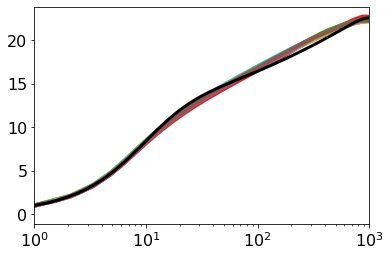

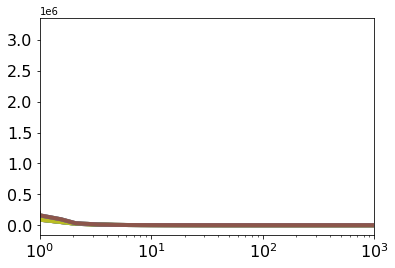

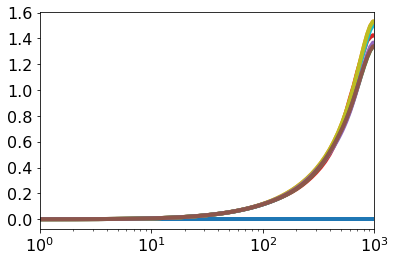

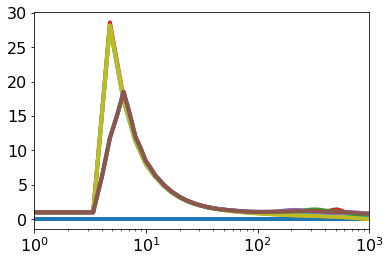

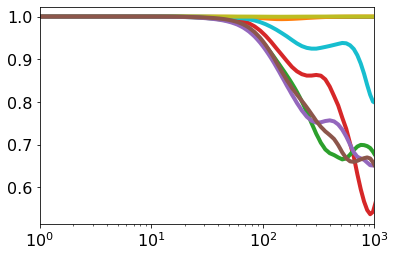

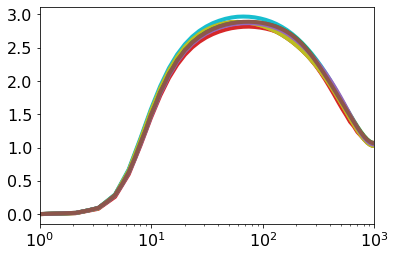

In [43]:
loc = "/Users/blmindell/Desktop/Jeremy/WorkFromHome/Nalu-Re1000/"
bn = "AMS-SST-Re1000"
bnLF = "AMS-SST-Re1000-lf"
ts = -1

channelNaluRANS = readNaluOutput(loc,bn,0)
channelNaluT1 = readNaluOutput(loc,bn,1)
channelNalu = readNaluOutput(loc,bn,ts)
channelNaluLF = readNaluOutput(loc,bnLF,ts)
channelNaluLFT1 = readNaluOutput(loc,bnLF,1)
channelCDPRANS = readCDPVisitOutput('/Users/blmindell/Desktop/Jeremy/WorkFromHome/CDP-Re1000/','planarAvgDict-ts',30000)
channelCDPT1 = readCDPVisitOutput('/Users/blmindell/Desktop/Jeremy/WorkFromHome/CDP-Re1000/','planarAvgDict-ts',30001)
channelCDP = readCDPVisitOutput('/Users/blmindell/Desktop/Jeremy/WorkFromHome/CDP-Re1000/','planarAvgDict-ts',30049)

pltCDP = plotCDPChannelTAMS(channelCDP, pltMultiple=True)
pltCDPT1 = plotCDPChannelTAMS(channelCDPT1, pltMultiple=True)
pltCDPRANS = plotCDPChannelTAMS(channelCDPRANS, pltMultiple=True)
pltNalu = plotNaluChannelTAMS(channelNalu, reTau=1000, pltMultiple=True)
pltNaluRANS = plotNaluChannelTAMS(channelNaluRANS, reTau=1000, pltMultiple=True)
pltNaluT1 = plotNaluChannelTAMS(channelNaluT1, reTau=1000, pltMultiple=True)
pltNaluLF = plotNaluChannelTAMS(channelNaluLF, reTau=1000, pltMultiple=True)
pltNaluLFT1 = plotNaluChannelTAMS(channelNaluLFT1, reTau=1000, pltMultiple=True)

plotChannelTAMS([pltNaluRANS, pltNalu, pltNaluT1, pltNaluLF, pltNaluLFT1, pltCDPRANS, pltCDP, pltCDPT1], reTau=1000, var=['velocity_x','specific_dissipation_rate','rans_time_scale','resolution_adequacy_parameter','k_ratio','turbulent_ke'])

(0.15, 2.0)

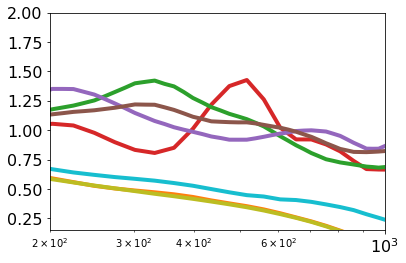

In [4]:
f, a = plotChannelTAMS([pltNaluRANS, pltNalu, pltNaluT1, pltNaluLF, pltNaluLFT1, pltCDPRANS, pltCDP, pltCDPT1], reTau=1000, var=['resolution_adequacy_parameter'], returnObject=True)

a.set_xlim(200,1000)
a.set_ylim(0.15,2)

(0.15, 5.0)

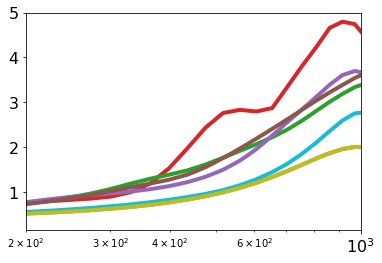

In [80]:
f, a = plotChannelTAMS([pltNaluRANS, pltNalu, pltNaluT1, pltNaluLF, pltNaluLFT1, pltCDPRANS, pltCDP, pltCDPT1], reTau=1000, var=['rkCoeff'], returnObject=True)

a.set_xlim(200,1000)
a.set_ylim(0.15,5)

(0.5, 1.0)

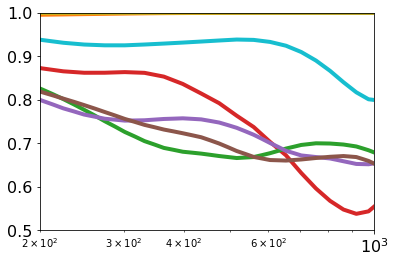

In [81]:
f, a = plotChannelTAMS([pltNaluRANS, pltNalu, pltNaluT1, pltNaluLF, pltNaluLFT1, pltCDPRANS, pltCDP, pltCDPT1], reTau=1000, var=['k_ratio'], returnObject=True)

a.set_xlim(200,1000)
a.set_ylim(0.5,1)

KeyError: 'average_dudx_1'

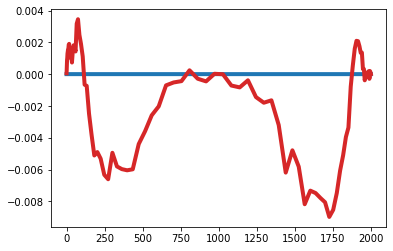

In [8]:
#f, a = plotChannelTAMS([pltNaluRANS, pltNalu, pltNaluT1, pltNaluLF, pltNaluLFT1, pltCDPRANS, pltCDP, pltCDPT1], reTau=1000, var=['turbulent_viscosity'], returnObject=True)

f, a = plotChannelTAMS([pltNaluRANS, pltNalu, pltCDPRANS, pltCDP], reTau=1000, var=['average_dudx_1'], returnObject=True)

a.set_xlim(200,1000)
a.set_ylim(0.025,0.15)

(0.025, 0.15)

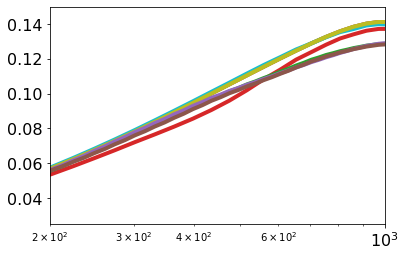

In [83]:
f, a = plotChannelTAMS([pltNaluRANS, pltNalu, pltNaluT1, pltNaluLF, pltNaluLFT1, pltCDPRANS, pltCDP, pltCDPT1], reTau=1000, var=['altTvisc'], returnObject=True)

a.set_xlim(200,1000)
a.set_ylim(0.025,0.15)

(1.0, 2.75)

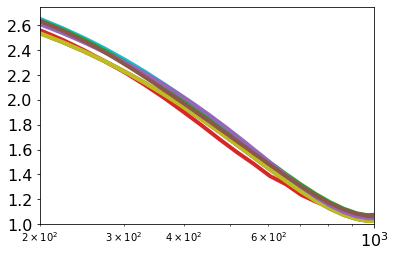

In [84]:
f, a = plotChannelTAMS([pltNaluRANS, pltNalu, pltNaluT1, pltNaluLF, pltNaluLFT1, pltCDPRANS, pltCDP, pltCDPT1], reTau=1000, var=['turbulent_ke'], returnObject=True)

a.set_xlim(200,1000)
a.set_ylim(1.0,2.75)

(5.0, 50.0)

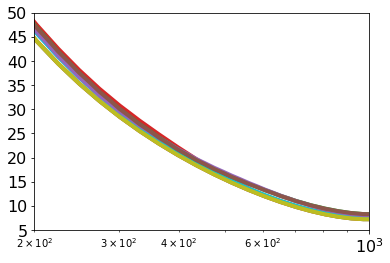

In [85]:
f, a = plotChannelTAMS([pltNaluRANS, pltNalu, pltNaluT1, pltNaluLF, pltNaluLFT1, pltCDPRANS, pltCDP, pltCDPT1], reTau=1000, var=['specific_dissipation_rate'], returnObject=True)

a.set_xlim(200,1000)
a.set_ylim(5,50)

Using a Re_tau value of  1000
Using a Re_tau value of  1000


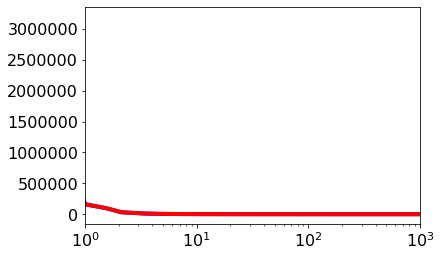

In [107]:
channelCDP = readCDPVisitOutput('/Users/blmindell/Desktop/Jeremy/WorkFromHome/CDP-Re1000/','planarAvgDict-ts',30000)
pltCDP = plotCDPChannelTAMS(channelCDP, pltMultiple=True)
channelCDP = readCDPVisitOutput('/Users/blmindell/Desktop/Jeremy/WorkFromHome/CDP-Re1000/','planarAvgDict-ts',30001)
pltCDP1 = plotCDPChannelTAMS(channelCDP, pltMultiple=True)
plotChannelTAMS([pltCDP,pltCDP1], reTau=1000, var=['specific_dissipation_rate'])

Value for Re_Tau of:  1000


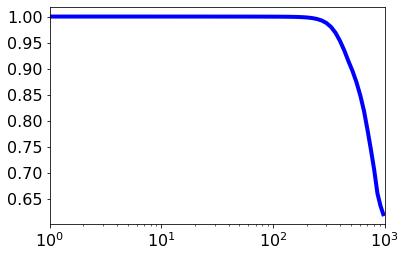

In [10]:
plotNaluChannelTAMS(channelData,reTau=1000,var=['k_ratio'])

In [146]:
fn = "/Users/blmindell/Desktop/Jeremy/WorkFromHome/Nalu-Re1000/channelflow-test.rst"
ts = -1
channelNaluConv = readSingleNaluOutput(fn,-1)
channelNaluTest = readSingleNaluOutput(fn,-2)

#pltNalu = plotNaluChannelTAMS(channelNalu, reTau=1000, pltMultiple=True)
#plotChannelTAMS([pltCDP,pltNalu], reTau=1000, var=['turbulent_ke'])

Analysis for time:  499.99999999969026
Analysis for time:  479.99999999970845


Value for Re_Tau of:  1000
Value for Re_Tau of:  1000


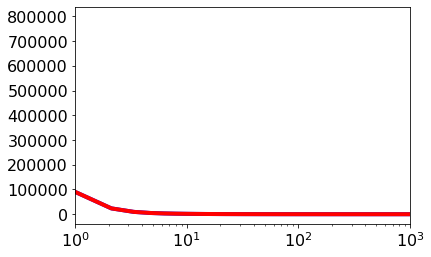

In [157]:
pltNaluConv = plotNaluChannelTAMS(channelNaluConv, reTau=1000, pltMultiple=True)
pltNaluTest = plotNaluChannelTAMS(channelNaluTest, reTau=1000, pltMultiple=True)

f,a = plotChannelTAMS([pltNaluConv,pltNaluTest], reTau=1000, var=['specific_dissipation_rate'],returnObject=True)
#a.set_xlim(100,1000)
#a.set_ylim(0,5)

(1, 30.0)

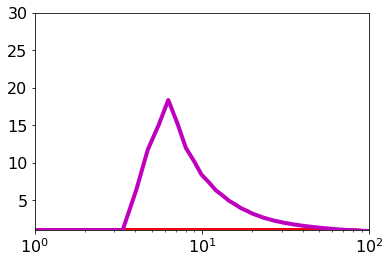

In [178]:
f,a = plotChannelTAMS([pltCDPRANS,pltCDPTAMS,pltCDPTEST], reTau=1000, var=['resolution_adequacy_parameter'],returnObject=True)
a.set_xlim(1,100)
a.set_ylim(1,30.0)

(0.9999999, 1.0000001)

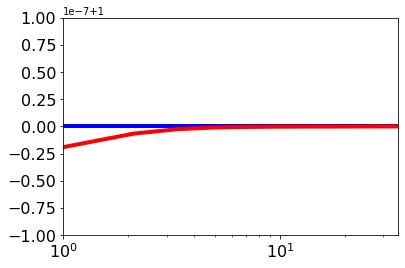

In [16]:
f,a = plotChannelTAMS([pltCDPTEST,pltNaluTEST], reTau=1000, var=['k_ratio'], returnObject=True)
a.set_xlim(1,35)
a.set_ylim(0.9999999,1.0000001)

(0, 1.0)

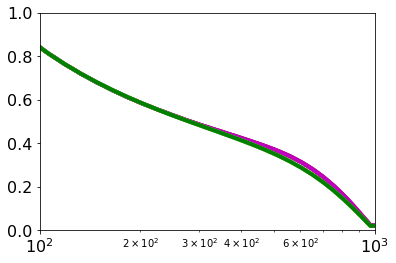

In [182]:
f,a = plotChannelTAMS([pltCDPRANS,pltCDPTAMS,pltCDPTEST,pltNaluRANS,pltNaluTAMS,pltNaluTEST], reTau=1000, var=['resolution_adequacy_parameter'],returnObject=True)
a.set_xlim(100,1000)
a.set_ylim(0,1.0)

Using a Re_tau value of  5200
Using a Re_tau value of  5200
Using a Re_tau value of  5200


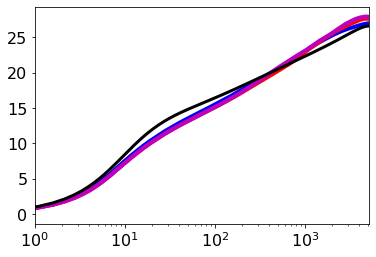

In [189]:
channelCDP = readCDPVisitOutput('/Users/blmindell/Desktop/Jeremy/WorkFromHome/CDP-Re5200/','planarAvgDict-ts',44000,reTau=5200)
pltCDP = plotCDPChannelTAMS(channelCDP, pltMultiple=True)
channelCDP = readCDPVisitOutput('/Users/blmindell/Desktop/Jeremy/WorkFromHome/CDP-Re5200/','planarAvgDict-ts',46000,reTau=5200)
pltCDP1 = plotCDPChannelTAMS(channelCDP, pltMultiple=True)
channelCDP = readCDPVisitOutput('/Users/blmindell/Desktop/Jeremy/WorkFromHome/CDP-Re5200/','planarAvgDict-ts',48000,reTau=5200)
pltCDP2 = plotCDPChannelTAMS(channelCDP, pltMultiple=True)
plotChannelTAMS([pltCDP,pltCDP1,pltCDP2], reTau=5200, var=['velocity_x'])

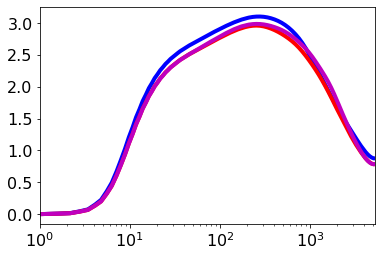

In [195]:
f,a = plotChannelTAMS([pltCDP,pltCDP1,pltCDP2], reTau=5200, var=['turbulent_ke'], returnObject=True)
#a.set_xlim(100,5200)
#a.set_ylim(0,3)

In [57]:
Nalu = pd.read_csv('/Users/blmindell/Desktop/Jeremy/WorkFromHome/CDP-PeriodicHill/profiles.dat')
CDP = pd.read_csv('/Users/blmindell/Desktop/Jeremy/WorkFromHome/CDP-PeriodicHill/dump.txt')
CDPRANS = pd.read_csv('/Users/blmindell/Desktop/Jeremy/WorkFromHome/CDP-PeriodicHill/dumpRANS.txt')

In [7]:
CDP

,x,y,u,v,w
0,0.05,1.000000,0.000028,2.091564e-07,9.882340e-07
1,0.05,1.010231,0.158722,-1.685658e-03,2.007453e-02
2,0.05,1.020462,0.327243,-3.558393e-04,2.705413e-02
3,0.05,1.030693,0.463567,6.080103e-03,3.287348e-02
4,0.05,1.040925,0.575407,1.633036e-02,3.496328e-02
...,...,...,...,...,...
1995,8.00,2.983982,0.665425,3.584723e-03,1.244622e-02
1996,8.00,2.996987,0.602006,2.654138e-03,1.213956e-02
1997,8.00,3.009991,0.507109,1.550375e-03,1.070112e-02
1998,8.00,3.022996,0.327499,4.684609e-04,6.656704e-03


In [8]:
Nalu

,x,y,u,v,w
0,0,1.001000,0.044238,-0.000059,-0.003220
1,0,1.002100,0.096423,-0.000229,-0.006673
2,0,1.003309,0.158040,-0.000530,-0.010318
3,0,1.004639,0.227532,-0.000915,-0.013321
4,0,1.006102,0.299967,-0.001298,-0.014513
...,...,...,...,...,...
1853,9,3.031640,0.172134,0.000030,0.006328
1854,9,3.033977,0.083724,-0.000011,0.003175
1855,9,3.033977,0.083704,-0.000008,0.003212
1856,9,3.033978,0.083726,-0.000006,0.003243


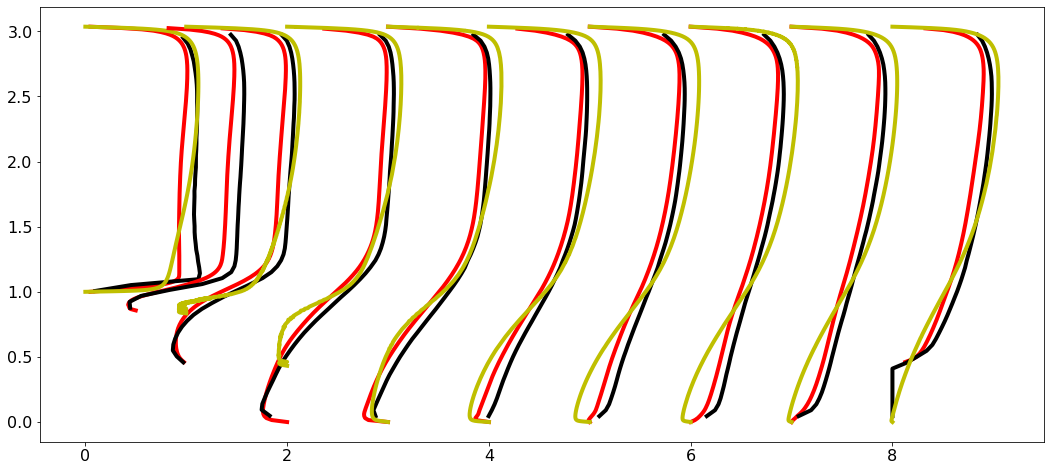

In [68]:
xsliceCDP = [0.0,0.5,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0]
xsliceNalu = [0.05,0.5,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0]
fig, ax = plt.subplots(figsize=(18, 8))
for i in range(0,len(xsliceCDP)): 
    #cdpSlice = CDP.loc[CDP.x == xsliceCDP[i]]
    #cdpSlice = cdpSlice.sort_values(by=['y'])
    cdpRSlice = CDPRANS.loc[CDPRANS.x == xsliceCDP[i]]
    cdpRSlice = cdpRSlice.sort_values(by=['y'])
    naluSlice = Nalu.loc[Nalu.x == xsliceNalu[i]]
    naluSlice = naluSlice.sort_values(by=['y'])
    expSlice = expData.loc[expData.x == xsliceNalu[i]]
    expSlice = expSlice.sort_values(by=['y'])
    #ax.plot(cdpSlice.u+cdpSlice.x,cdpSlice.y,'b',linewidth=4)
    ax.plot(naluSlice.u+naluSlice.x,naluSlice.y,'r',linewidth=4)
    ax.plot(expSlice.u+expSlice.x,expSlice.y,'k',linewidth=4)
    ax.plot(cdpRSlice.u+cdpRSlice.x,cdpRSlice.y,'y',linewidth=4)
    #ax.set_xscale('log')
    #ax.set_xlim([1, reTau])

    for label in ax.get_xticklabels():
        label.set_fontsize(16)
    for label in ax.get_yticklabels():
        label.set_fontsize(16)  
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    ax.title.set_size(16)
plt.show()

In [48]:
exp0 = pd.read_csv('/Users/blmindell/Desktop/Jeremy/WorkFromHome/periodicHill/refdata/exp/UFR3-30_X_10600_data_CR-001.dat',skiprows=6,header=None,names=['y','u','v','uu','vv','uv'])
exp0 = exp0.loc[exp0.y >= 1.0]
exp0['x'] = 0.05
exp1 = pd.read_csv('/Users/blmindell/Desktop/Jeremy/WorkFromHome/periodicHill/refdata/exp/UFR3-30_X_10600_data_CR-002.dat',skiprows=6,header=None,names=['y','u','v','uu','vv','uv'])
exp1 = exp1.loc[exp1.y >= 0.85]
exp1['x'] = 0.5
exp2 = pd.read_csv('/Users/blmindell/Desktop/Jeremy/WorkFromHome/periodicHill/refdata/exp/UFR3-30_X_10600_data_CR-003.dat',skiprows=6,header=None,names=['y','u','v','uu','vv','uv'])
exp2 = exp2.loc[exp2.y >= 0.44]
exp2['x'] = 1.0
exp3 = pd.read_csv('/Users/blmindell/Desktop/Jeremy/WorkFromHome/periodicHill/refdata/exp/UFR3-30_X_10600_data_CR-004.dat',skiprows=6,header=None,names=['y','u','v','uu','vv','uv'])
exp3['x'] = 2.0
exp4 = pd.read_csv('/Users/blmindell/Desktop/Jeremy/WorkFromHome/periodicHill/refdata/exp/UFR3-30_X_10600_data_CR-005.dat',skiprows=6,header=None,names=['y','u','v','uu','vv','uv'])
exp4['x'] = 3.0
exp5 = pd.read_csv('/Users/blmindell/Desktop/Jeremy/WorkFromHome/periodicHill/refdata/exp/UFR3-30_X_10600_data_CR-006.dat',skiprows=6,header=None,names=['y','u','v','uu','vv','uv'])
exp5['x'] = 4.0
exp6 = pd.read_csv('/Users/blmindell/Desktop/Jeremy/WorkFromHome/periodicHill/refdata/exp/UFR3-30_X_10600_data_CR-007.dat',skiprows=6,header=None,names=['y','u','v','uu','vv','uv'])
exp6['x'] = 5.0
exp7 = pd.read_csv('/Users/blmindell/Desktop/Jeremy/WorkFromHome/periodicHill/refdata/exp/UFR3-30_X_10600_data_CR-008.dat',skiprows=6,header=None,names=['y','u','v','uu','vv','uv'])
exp7['x'] = 6.0
exp8 = pd.read_csv('/Users/blmindell/Desktop/Jeremy/WorkFromHome/periodicHill/refdata/exp/UFR3-30_X_10600_data_CR-009.dat',skiprows=6,header=None,names=['y','u','v','uu','vv','uv'])
exp8['x'] = 7.0
exp9 = pd.read_csv('/Users/blmindell/Desktop/Jeremy/WorkFromHome/periodicHill/refdata/exp/UFR3-30_X_10600_data_CR-010.dat',skiprows=6,header=None,names=['y','u','v','uu','vv','uv'])
exp9['x'] = 8.0

expData = pd.concat([exp0,exp1,exp2,exp3,exp4,exp5,exp6,exp7,exp8,exp9])

In [54]:
Nalu

,x,y,u,v,w
0,0.05,1.000000,0.000028,2.091564e-07,9.882340e-07
1,0.05,1.010231,0.158722,-1.685658e-03,2.007453e-02
2,0.05,1.020462,0.327243,-3.558393e-04,2.705413e-02
3,0.05,1.030693,0.463567,6.080103e-03,3.287348e-02
4,0.05,1.040925,0.575407,1.633036e-02,3.496328e-02
...,...,...,...,...,...
1995,8.00,2.983982,0.665425,3.584723e-03,1.244622e-02
1996,8.00,2.996987,0.602006,2.654138e-03,1.213956e-02
1997,8.00,3.009991,0.507109,1.550375e-03,1.070112e-02
1998,8.00,3.022996,0.327499,4.684609e-04,6.656704e-03


In [65]:
test = CDPRANS.loc[CDPRANS.x == 4.0]

In [66]:
test.y.unique()

array([4.65300958e-01, 4.46496028e-01, 4.84093403e-01, 5.02876006e-01,
       5.21651072e-01, 5.40421979e-01, 5.59192168e-01, 5.77965874e-01,
       6.01532924e-01, 6.27007430e-01, 6.54494600e-01, 6.84096455e-01,
       7.15909255e-01, 7.50021628e-01, 7.86511699e-01, 4.27677165e-01,
       8.25444446e-01, 3.33324719e-01, 3.52232553e-01, 3.71120821e-01,
       3.89990646e-01, 4.08842247e-01, 3.14397490e-01, 2.95450329e-01,
       2.00424328e-01, 1.81363647e-01, 2.19467055e-01, 2.38491578e-01,
       2.57497191e-01, 2.76483634e-01, 1.64021022e-01, 1.33891032e-01,
       1.48243485e-01, 1.20836338e-01, 1.08962747e-01, 8.66868648e-01,
       9.10814106e-01, 9.57583849e-01, 9.57288499e-01, 9.81643993e-02,
       6.39110943e-02, 7.12943945e-02, 7.94144766e-02, 8.83442792e-02,
       3.59110869e-02, 4.04985296e-02, 4.55441936e-02, 5.10939013e-02,
       5.71977442e-02, 3.17403874e-02, 2.79485567e-02, 2.45011959e-02,
       2.13670281e-02, 1.85175081e-02, 1.59268901e-02, 1.35714210e-02,
      

In [7]:
len(channelNalu.y.unique())

8536

In [17]:
len((channelNalu.loc[(channelNalu.x == 0.0) & (channelNalu.y == 0.0)]).z.unique())

9

In [16]:
len((channelNalu.loc[(channelNalu.y == 0.0) & (channelNalu.z == 0.0)]).x.unique())

18

In [19]:
len((channelNalu.loc[(channelNalu.x == 0.0) & (channelNalu.z == 0.0)]).y.unique())

100

In [20]:
6.28/0.36

17.444444444444446

In [21]:
3.14/9

0.3488888888888889

In [22]:
3.14/8

0.3925

In [23]:
6.28/17

0.3694117647058824

In [24]:
f = nc.Dataset('/Users/blmindell/Desktop/Jeremy/WorkFromHome/PeriodicChannel-SWH.exo')

In [29]:
large = pd.DataFrame({'x' : f['coordx'][:], 'y' : f['coordy'][:], 'z' : f['coordz'][:]})

In [49]:
large.loc[(large.z == 0.0) & (large.x == 0.0) & (large.y >= 0.0025) & (large.y <= 1.9975)].y

1260     0.002523
1400     0.002931
1540     0.003373
1680     0.003851
1820     0.004368
           ...   
21840    1.995632
21980    1.996149
22120    1.996627
22260    1.997069
22400    1.997477
Name: y, Length: 152, dtype: float64

In [47]:
len(channelNalu.loc[(channelNalu.y == 0.0) & (channelNalu.x == 0.0)].z.unique())

9

(200, 1000)

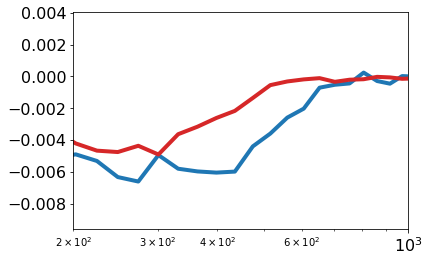

In [26]:
f, a = plotChannelTAMS([pltNalu, pltNaluLF], reTau=1000, var=['s11'], returnObject=True)

a.set_xlim(200,1000)
#a.set_ylim(0.025,0.15)

(200, 1000)

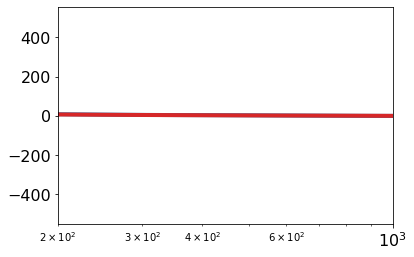

In [27]:
f, a = plotChannelTAMS([pltNalu, pltNaluLF], reTau=1000, var=['s12'], returnObject=True)

a.set_xlim(200,1000)
#a.set_ylim(0.025,0.15)

(200, 1000)

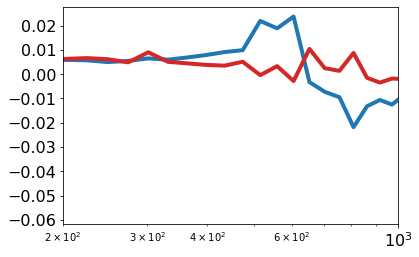

In [28]:
f, a = plotChannelTAMS([pltNalu, pltNaluLF], reTau=1000, var=['s13'], returnObject=True)

a.set_xlim(200,1000)
#a.set_ylim(0.025,0.15)

(200, 1000)

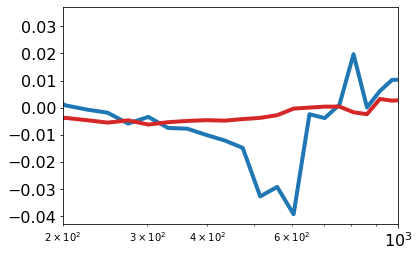

In [30]:
f, a = plotChannelTAMS([pltNalu, pltNaluLF], reTau=1000, var=['s22'], returnObject=True)

a.set_xlim(200,1000)
#a.set_ylim(0.025,0.15)

(200, 1000)

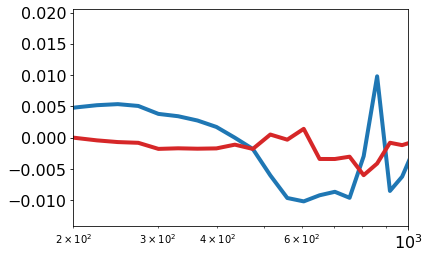

In [31]:
f, a = plotChannelTAMS([pltNalu, pltNaluLF], reTau=1000, var=['s23'], returnObject=True)

a.set_xlim(200,1000)
#a.set_ylim(0.025,0.15)

(200, 1000)

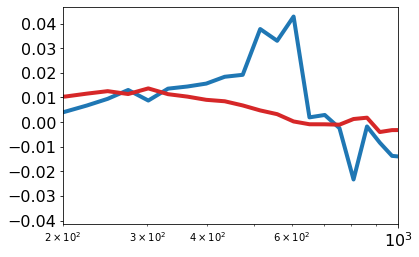

In [32]:
f, a = plotChannelTAMS([pltNalu, pltNaluLF], reTau=1000, var=['s33'], returnObject=True)

a.set_xlim(200,1000)
#a.set_ylim(0.025,0.15)

(0.0, 20.0)

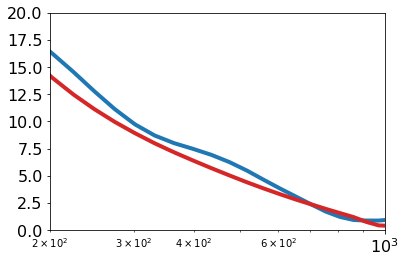

In [37]:
f, a = plotChannelTAMS([pltNalu, pltNaluLF], reTau=1000, var=['Smag'], returnObject=True)

a.set_xlim(200,1000)
a.set_ylim(0.,20)

(0.025, 0.15)

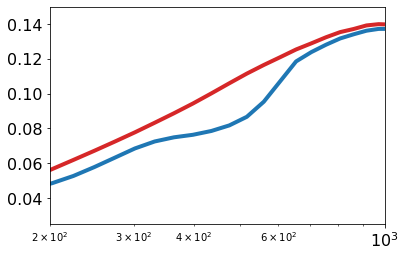

In [39]:
f, a = plotChannelTAMS([pltNalu, pltNaluLF], reTau=1000, var=['turbulent_viscosity'], returnObject=True)

a.set_xlim(200,1000)
a.set_ylim(0.025,0.15)

(0.0, 20.0)

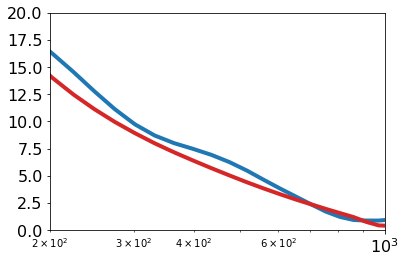

In [53]:
f, a = plotChannelTAMS([pltNalu, pltNaluLF], reTau=1000, var=['Smag'], returnObject=True)

a.set_xlim(200,1000)
a.set_ylim(0.,20)

(0.0, 20.0)

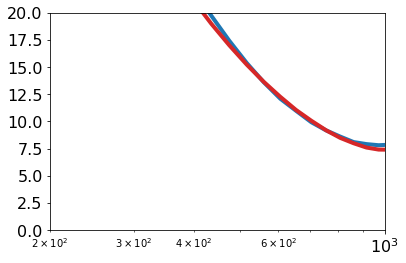

In [54]:
f, a = plotChannelTAMS([pltNalu, pltNaluLF], reTau=1000, var=['specific_dissipation_rate'], returnObject=True)

a.set_xlim(200,1000)
a.set_ylim(0.,20)

(0.0, 20.0)

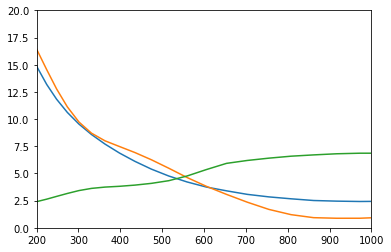

In [73]:
fig, ax = plt.subplots()
ax.plot(pltNalu['y'],0.31*pltNalu['specific_dissipation_rate'])
ax.plot(pltNalu['y'],pltNalu['Smag'])
ax.plot(pltNalu['y'],50*pltNalu['turbulent_viscosity'])
ax.set_xlim(200,1000)
ax.set_ylim(0.,20)
#ax.set_xscale('log')

(0.0, 20.0)

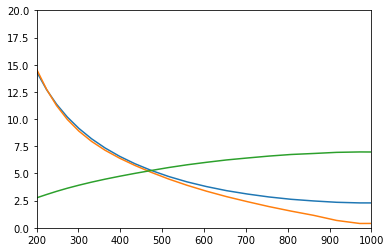

In [82]:
fig, ax = plt.subplots()
ax.plot(pltNaluLFTE2['y'],0.31*pltNaluLFTE2['specific_dissipation_rate'])
ax.plot(pltNaluLFTE2['y'],pltNaluLFTE2['Smag'])
ax.plot(pltNaluLFTE2['y'],50*pltNaluLFTE2['turbulent_viscosity'])
ax.set_xlim(200,1000)
ax.set_ylim(0.,20)
#ax.set_xscale('log')

(0.0, 20.0)

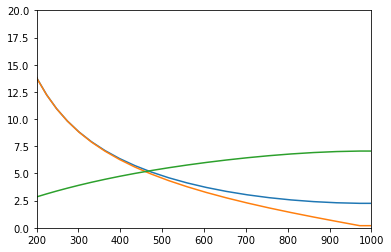

In [75]:
fig, ax = plt.subplots()
ax.plot(pltNaluRANS['y'],0.31*pltNaluRANS['specific_dissipation_rate'])
ax.plot(pltNaluRANS['y'],pltNaluRANS['Smag'])
ax.plot(pltNaluRANS['y'],50*pltNaluRANS['turbulent_viscosity'])
ax.set_xlim(200,1000)
ax.set_ylim(0.,20)
#ax.set_xscale('log')

(0.0, 20.0)

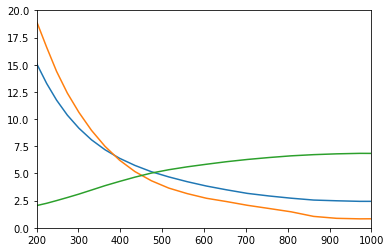

In [84]:
fig, ax = plt.subplots()
ax.plot(pltNaluTE2['y'],0.31*pltNaluTE5['specific_dissipation_rate'])
ax.plot(pltNaluTE2['y'],pltNaluTE5['Smag'])
ax.plot(pltNaluTE2['y'],50*pltNaluTE5['turbulent_viscosity'])
ax.set_xlim(200,1000)
ax.set_ylim(0.,20)
#ax.set_xscale('log')

In [77]:
loc = "/Users/blmindell/Desktop/Jeremy/WorkFromHome/Nalu-Re1000/"
bn = "AMS-SST-Re1000"
bnLF = "AMS-SST-Re1000-lf"
ts = -2

channelNaluTE2 = readNaluOutput(loc,bn,ts)
channelNaluLFTE2 = readNaluOutput(loc,bnLF,ts)
channelNaluTE5 = readNaluOutput(loc,bn,-5)
channelNaluLFTE5 = readNaluOutput(loc,bnLF,-5)

pltNaluTE2 = plotNaluChannelTAMS(channelNaluTE2, reTau=1000, pltMultiple=True)
pltNaluLFTE2 = plotNaluChannelTAMS(channelNaluLFTE2, reTau=1000, pltMultiple=True)
pltNaluTE5 = plotNaluChannelTAMS(channelNaluTE5, reTau=1000, pltMultiple=True)
pltNaluLFTE5 = plotNaluChannelTAMS(channelNaluLFTE5, reTau=1000, pltMultiple=True)
#plotChannelTAMS([pltNaluRANS, pltNalu, pltNaluT1, pltNaluLF, pltNaluLFT1, pltCDPRANS, pltCDP, pltCDPT1], reTau=1000, var=['velocity_x','specific_dissipation_rate','rans_time_scale','resolution_adequacy_parameter','k_ratio','turbulent_ke'])

Analysis for time:  579.5999999981491
 Finished reading output file 1 of 36

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


 Finished reading output file 36 of 36Analysis for time:  579.5999999981491
 Finished reading output file 36 of 36Analysis for time:  578.3999999981775
 Finished reading output file 36 of 36Analysis for time:  578.3999999981775
 Finished reading output file 36 of 36Value for Re_Tau of:  1000
Value for Re_Tau of:  1000
Value for Re_Tau of:  1000
Value for Re_Tau of:  1000


In [3]:
loc = "/Users/blmindell/Desktop/Jeremy/WorkFromHome/Nalu-Re1000/"
bn = "AMS-SST-Re1000-flipIsoSign"
ts = -1

locBase = loc
bnBase = "AMS-SST-Re1000"
tsBase = -1

channelNalu = readNaluOutput(loc,bn,ts)
channelNaluBase = readNaluOutput(locBase, bnBase, tsBase)

pltNalu = plotNaluChannelTAMS(channelNalu, reTau=1000, pltMultiple=True)
pltNaluBase = plotNaluChannelTAMS(channelNaluBase, reTau=1000, pltMultiple=True)

Analysis for time:  579.9999999981396
Reading 36 output files...

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


 Finished reading output file 36 of 36Analysis for time:  579.9999999981396
 Finished reading output file 36 of 36Value for Re_Tau of:  1000
Value for Re_Tau of:  1000


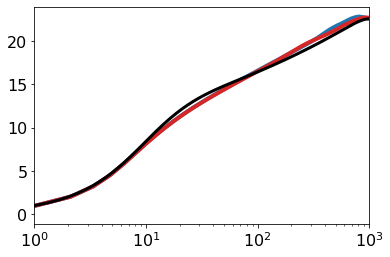

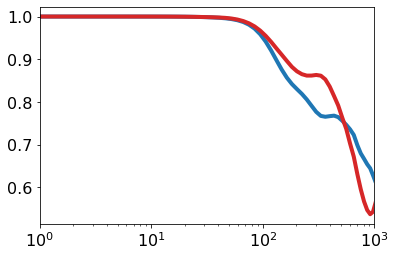

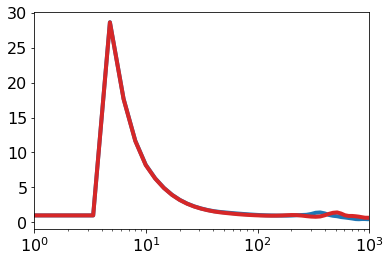

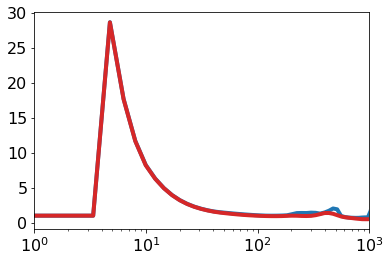

In [14]:
plotChannelTAMS([pltNalu, pltNaluBase], reTau=1000, var=['velocity_x', 'k_ratio','resolution_adequacy_parameter','avg_res_adequacy_parameter'])

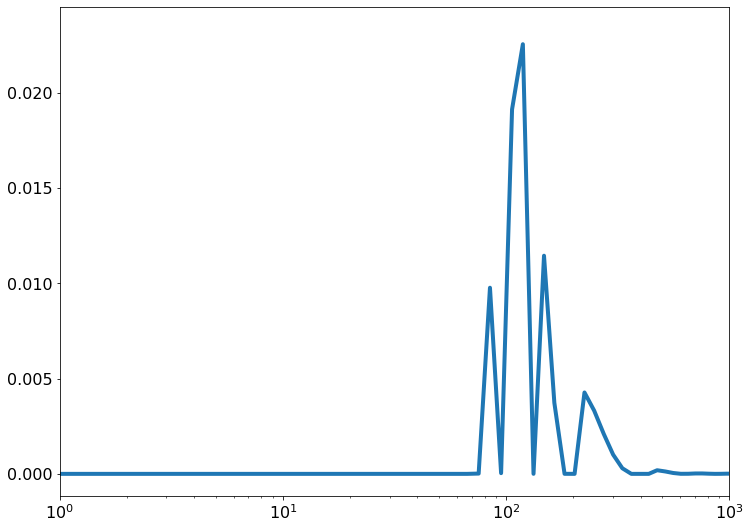

In [27]:
plotChannelTAMS([pltNalu], reTau=1000, var=['Fy_var'])

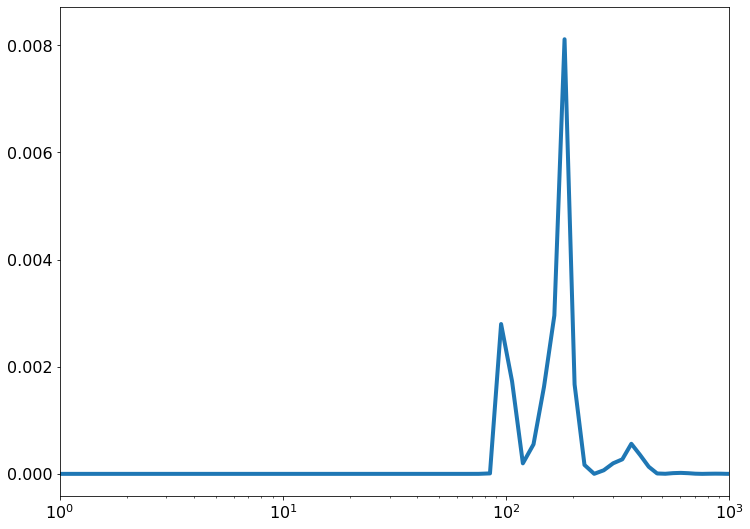

In [28]:
plotChannelTAMS([pltNalu], reTau=1000, var=['Fz_var'])